In [1]:
import matplotlib.pyplot as plt
from utils.data_analysis import *
from matplotlib.patches import Patch
import os
from sklearn.metrics import auc
from statsmodels.graphics.boxplots import violinplot
from utils.evals import load_results
from utils.data_analysis import align_dataframe, get_p_values, get_score_from_p_values

In [22]:
# Load all data (1.0 sec)
dataset = 'amazon-google'
model = 'timesfm'

anomaly_dataset = f'{dataset}_anomaly'

data_df, results_df, freq_delta, quantiles_dict = load_results(anomaly_dataset, model)
parse_dates = [str(i) for i in np.unique(data_df['unique_id'])]
anomaly_dates = pd.read_csv(f'data/{anomaly_dataset}/loc_{anomaly_dataset}.csv', index_col=0, \
                            parse_dates=parse_dates, date_format="%Y-%m-%d %H:%M:%S")
true_data_df, true_results_df, _, true_quantiles_dict = load_results(dataset, model)

In [24]:
# Get P-values (linear below 0.1 and non-symmetrical gaussian else) (1.9 sec)

ks = [str(i) for i in range(1,49)]
low_quantile = 0.1
high_quantile = 0.9
min_std = -1

# Setup low/high timestamps
low_time = min(results_df['ds'])
high_time = max(results_df['ds'])

# Load Anomalous Forecasts + preprocessing
df = align_dataframe(data_df, results_df)
lower_df = align_dataframe(data_df, quantiles_dict[low_quantile])
higher_df = align_dataframe(data_df, quantiles_dict[high_quantile])
# Get P-values
p_df = get_p_values(df, lower_df, higher_df, min_std=min_std)

# Load Non-Anomalous Forecasts + preprocessing
true_df = align_dataframe(true_data_df, true_results_df)
true_lower_df = align_dataframe(true_data_df, quantiles_dict[low_quantile])
true_higher_df = align_dataframe(true_data_df, quantiles_dict[high_quantile])
# Get P-values
true_p_df = get_p_values(true_df, true_lower_df, true_higher_df, min_std=min_std)

# Get Score
methods = ['arithmetic', 'geometric', 'fisher']
score_dict = {'anomaly': {}, 'true': {}}
for method in methods:
    score_dict['anomaly'][method] = get_score_from_p_values(p_df, method)
    score_dict['true'][method] = get_score_from_p_values(true_p_df, method)

/extra/datalab_scratch0/ctadler/time_series_models/uni2ts/venv/lib/python3.10/site-packages/pandas/core/arraylike.py:396: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


# Numerical Results (ROC-AUC)

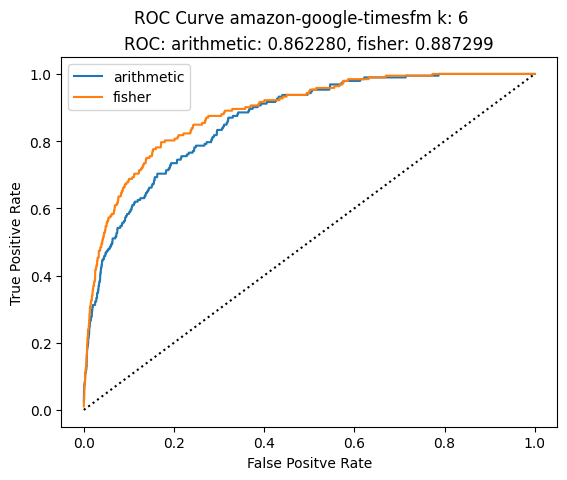

In [ ]:
# Get ROC curve (6.1 sec)
for k in ["6"]: # Num steps ahead
    auc_dict = {}
    for method_name in methods:
        if method_name == 'geometric':
            continue
        tpr, fpr = roc_curve(score_dict['anomaly'][method_name], method_name, anomaly_dates, k)
        plt.plot(fpr, tpr, label=method_name)
        auc_dict[method_name] = auc(fpr, tpr)
        
    plt.xlabel("False Positve Rate")
    plt.ylabel("True Positive Rate")
    plt.suptitle(f"ROC Curve {dataset}-{model} k: {k}")
    plt.legend()
    plt.plot([0,1], [0,1], c='black', linestyle=":")
    plt.title(f"ROC: arithmetic: {auc_dict['arithmetic']:.6f}, fisher: {auc_dict['fisher']:.6f}")
    plt.show()

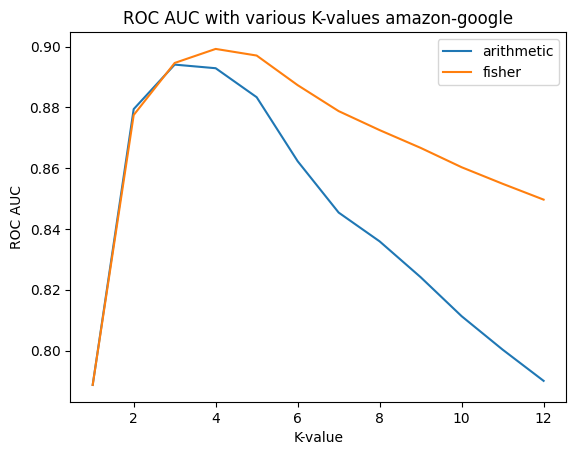

In [ ]:
# Get ROC AUC for different k-values (72.3 sec)
roc_auc = {'arithmetic': [], 'geometric': [], 'fisher': []}
for method_name in methods:
    if method_name == 'geometric':
        continue
    for k in range(1,13):
        tpr, fpr = roc_curve(score_dict['anomaly'][method_name], method_name, anomaly_dates, str(k))
        roc_auc[method_name].append(auc(fpr, tpr))
    plt.plot(range(1,13), roc_auc[method_name], label=method_name)
plt.xlabel("K-value")
plt.ylabel("ROC AUC")
plt.title(f"ROC AUC with various K-values {dataset}")
plt.legend()
plt.show()

# Forecast Plots

In [ ]:
# Setup plotting functions
def plot_forecasts(df, lower_df, higher_df, id, timestamp, freq_delta, steps_ahead, mat_plt=plt):
    x = [timestamp+freq_delta*i for i in range(1,steps_ahead+1)]
    pred_ind = [str(i) for i in range(1,steps_ahead+1)]
    # Plot point forecast values
    mat_plt.plot(x, df.loc[(df["unique_id"]==id) & (df["ds"]==timestamp), pred_ind].to_numpy().flatten(), \
                 label=f"{model}", linewidth=1, c='b')
    # Plot confidence interval
    lower_pred = lower_df.loc[(df["unique_id"]==id) & (df["ds"]==timestamp), pred_ind].to_numpy().flatten()
    higher_pred = higher_df.loc[(df["unique_id"]==id) & (df["ds"]==timestamp), pred_ind].to_numpy().flatten()
    mat_plt.fill_between(x, lower_pred, higher_pred, color='b', alpha=0.3)  

def plot_df(df, id, timestamp, freq_delta, graph_before, steps_ahead, mat_plt=plt):
    y = df.loc[(df["unique_id"]==id) & (df["ds"]>=timestamp-graph_before*freq_delta) & \
                         (df["ds"]<timestamp+max(steps_ahead,48)*freq_delta), "y"].to_numpy().flatten()
    mat_plt.plot(df.loc[(df["unique_id"]==id) & (df["ds"]>=timestamp-graph_before*freq_delta) & \
                             (df["ds"]<timestamp+max(steps_ahead,48)*freq_delta), "ds"].to_numpy().flatten(), \
                                y, label=f"True", linewidth=1, color='r')

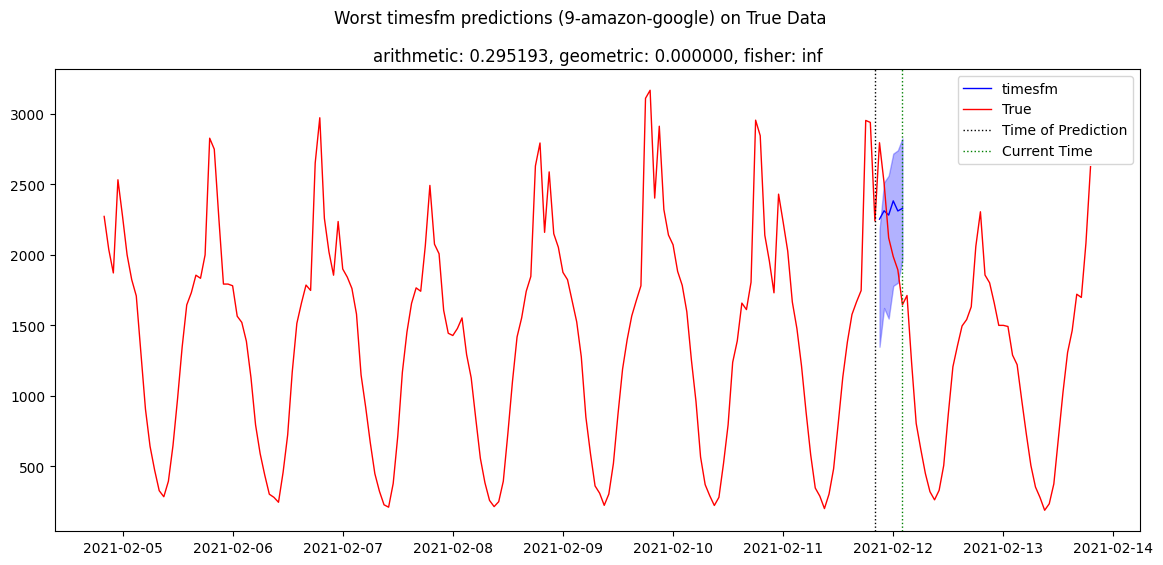

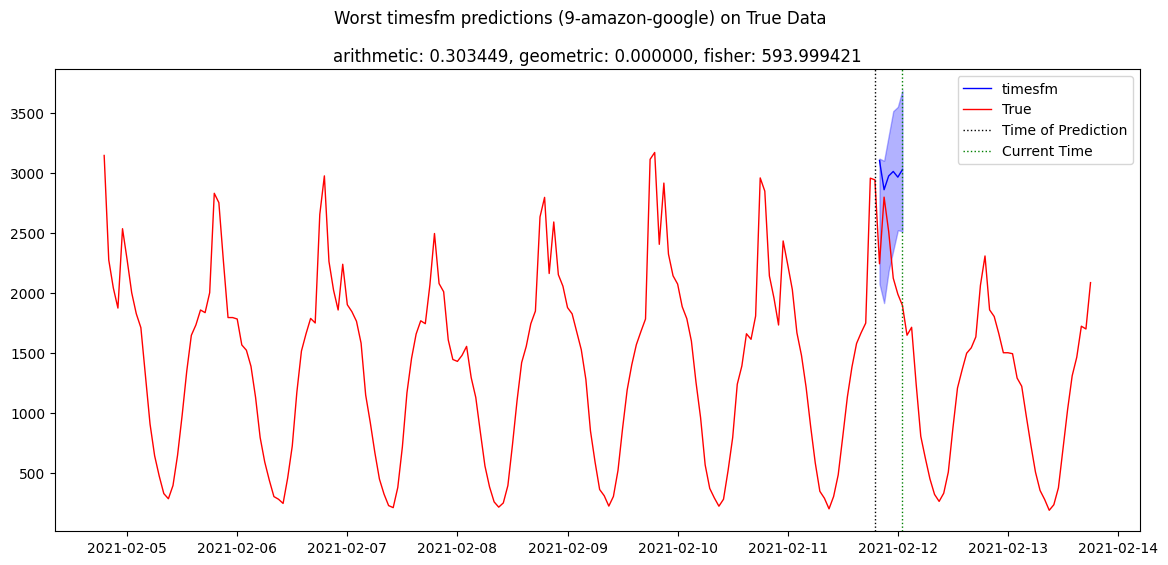

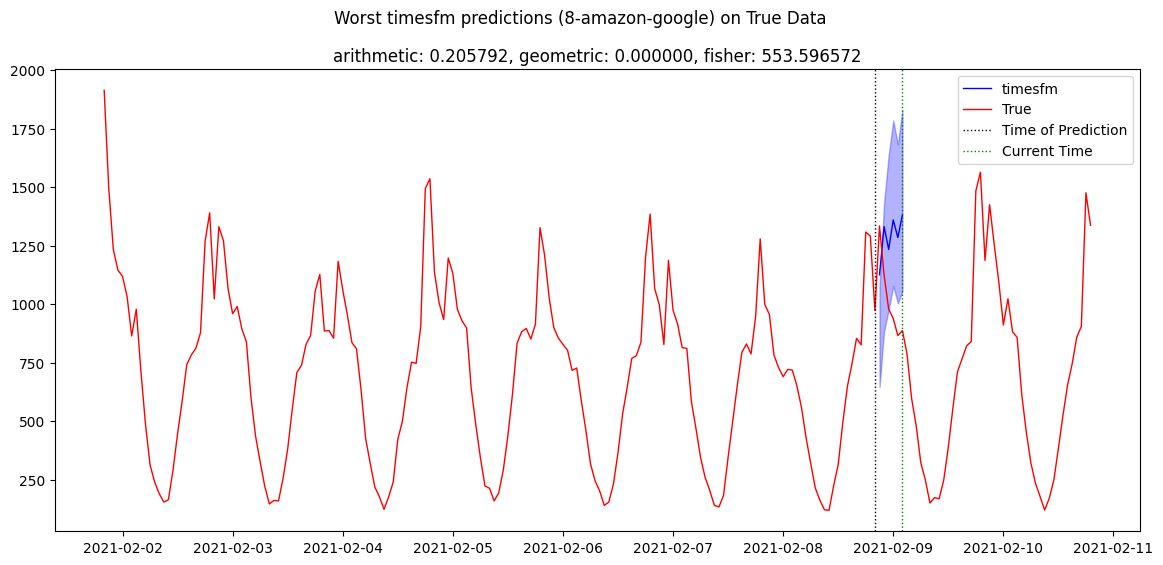

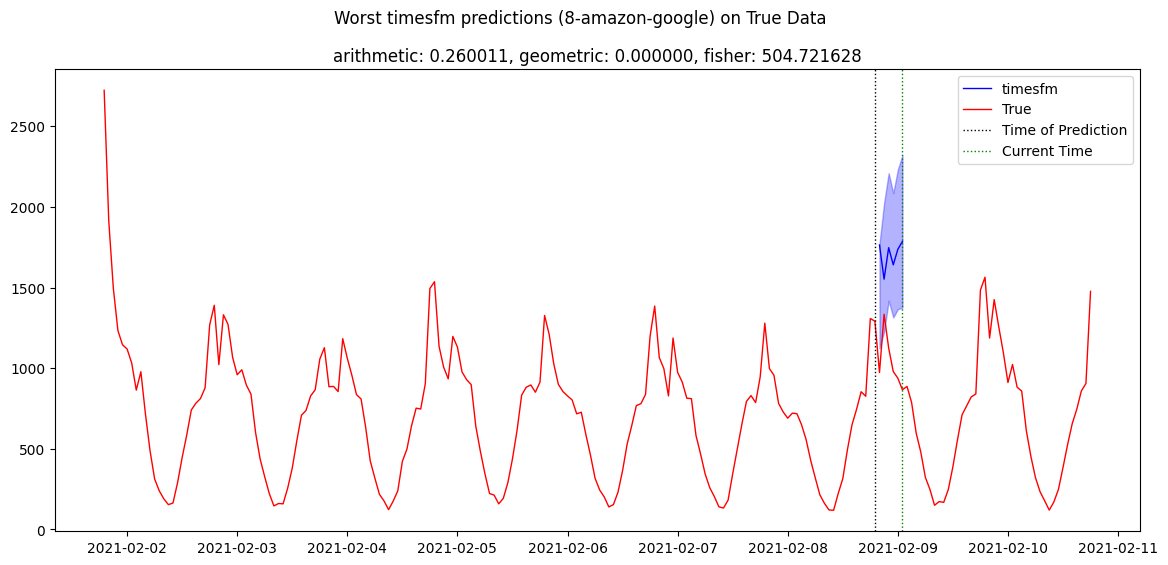

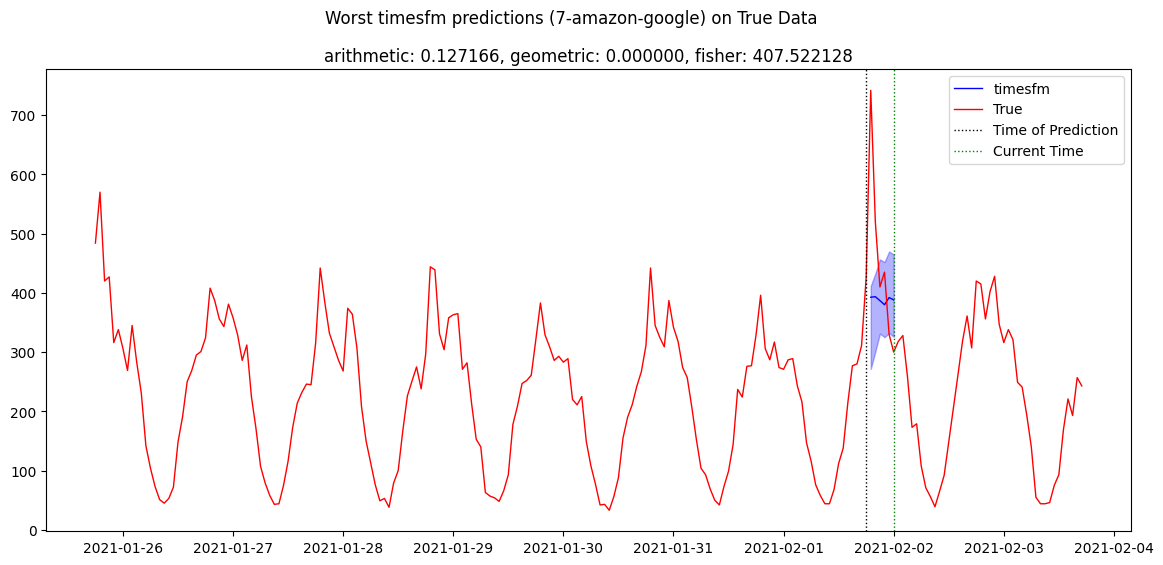

In [43]:
# Get worst scoring predictions for each timeseries (non-anomalous data)
k = "6" # Pred Horizon
method_name = "fisher"
steps_ahead = int(k)
graph_before = 24*7

# Get top-k scores or worst score from each time series
use_topk = True
top_k = 5

if method_name == 'fisher': # higher is worse
    worst_args = np.argsort(score_dict['true'][method_name][k])[::-1]
else: # lower is worse
    worst_args = np.argsort(score_dict['true'][method_name][k])[::1]
    
ids = set()
for counter, i in enumerate(worst_args):
    id = score_dict['true'][method_name].iloc[i,0]
    timestamp = score_dict['true'][method_name].iloc[i,1]
    if use_topk:
        if counter == top_k:
            break
    else:
        if id in ids:
            continue
        ids.add(id)

    plt.figure(figsize=(14,6))
    plot_forecasts(true_df, true_lower_df, true_higher_df, id, timestamp, freq_delta, steps_ahead)
    plot_df(true_data_df, id, timestamp, freq_delta, graph_before, steps_ahead)
    plt.axvline(x=timestamp, color='black', linewidth=1, linestyle=':', label='Time of Prediction')
    plt.axvline(x=timestamp+pd.Timedelta(steps_ahead, 'h'), color='green', linewidth=1, linestyle=':', label='Current Time')

    score = score_dict['true'][method_name].loc[(score_dict['true'][method_name]["unique_id"]==id) & \
                                                        (score_dict['true'][method_name]["ds"]==timestamp), k].item()
    scores = {}
    for score_method, score_df_method in score_dict['true'].items():
        scores[score_method] = score_df_method.loc[(score_df_method["unique_id"]==id) & (score_df_method["ds"]==timestamp), k].item()
    plt.suptitle(f"Worst {model} predictions ({id}-{dataset}) on True Data")
    plt.title(f"arithmetic: {scores['arithmetic']:.6f}, geometric: {scores['geometric']:.6f}, fisher: {scores['fisher']:.6f}")
    plt.legend()
    plt.show()


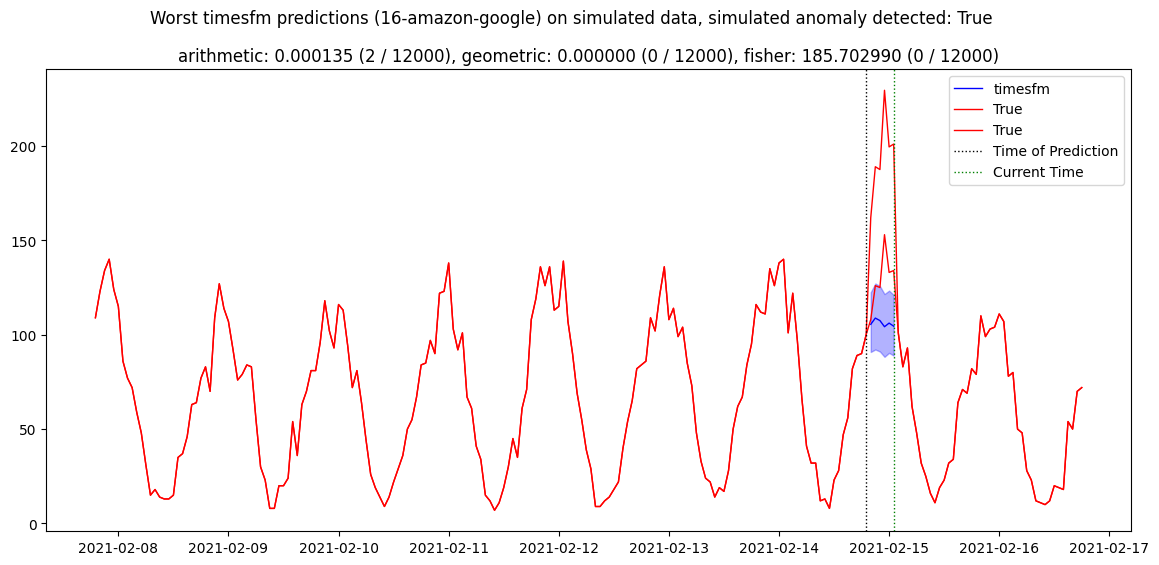

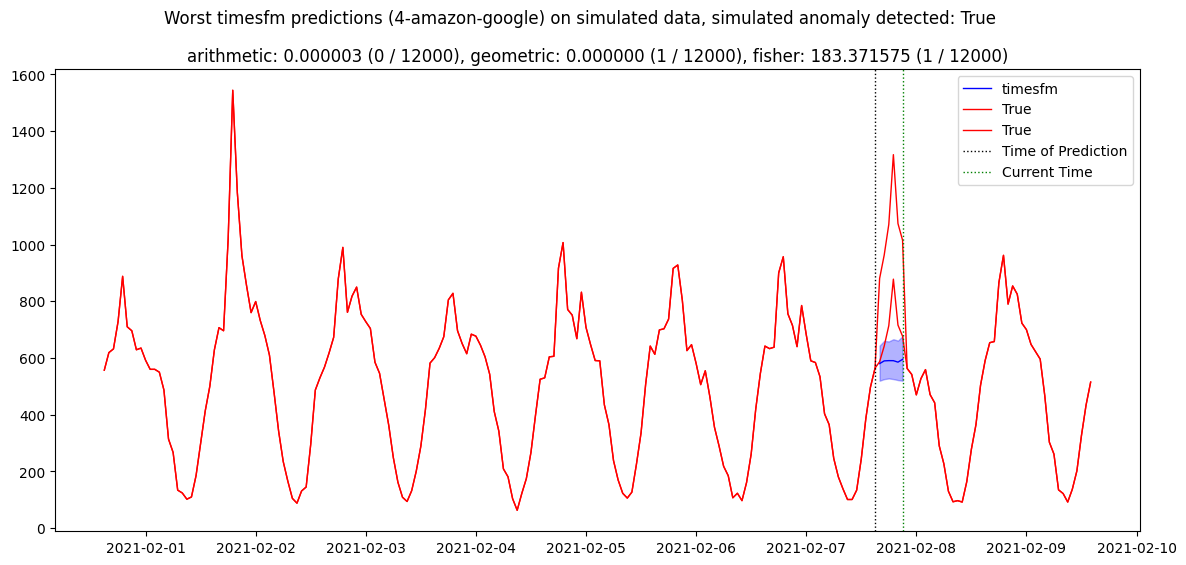

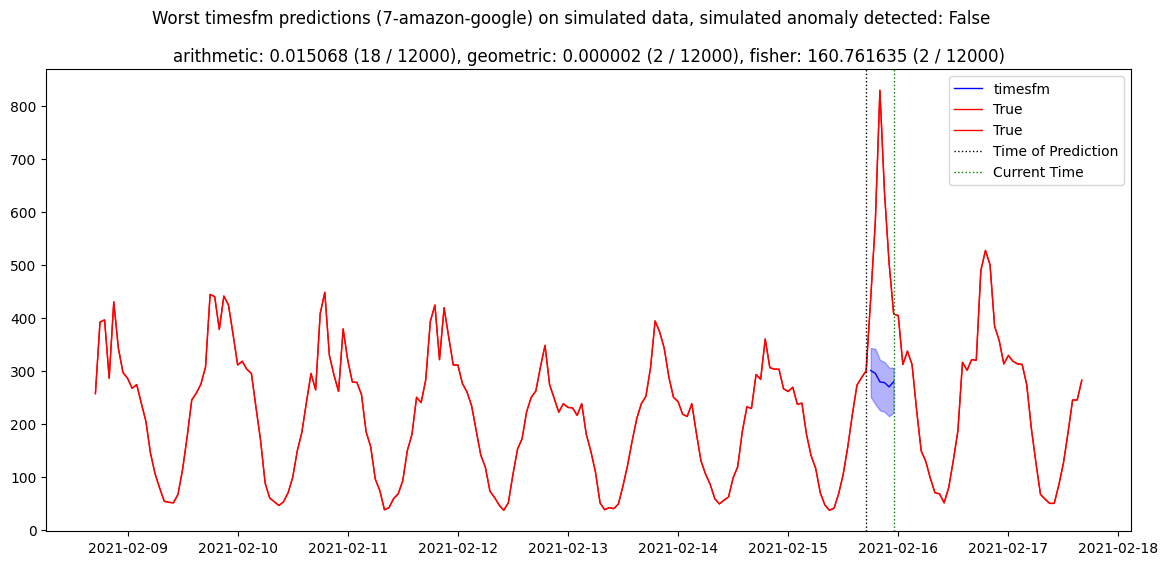

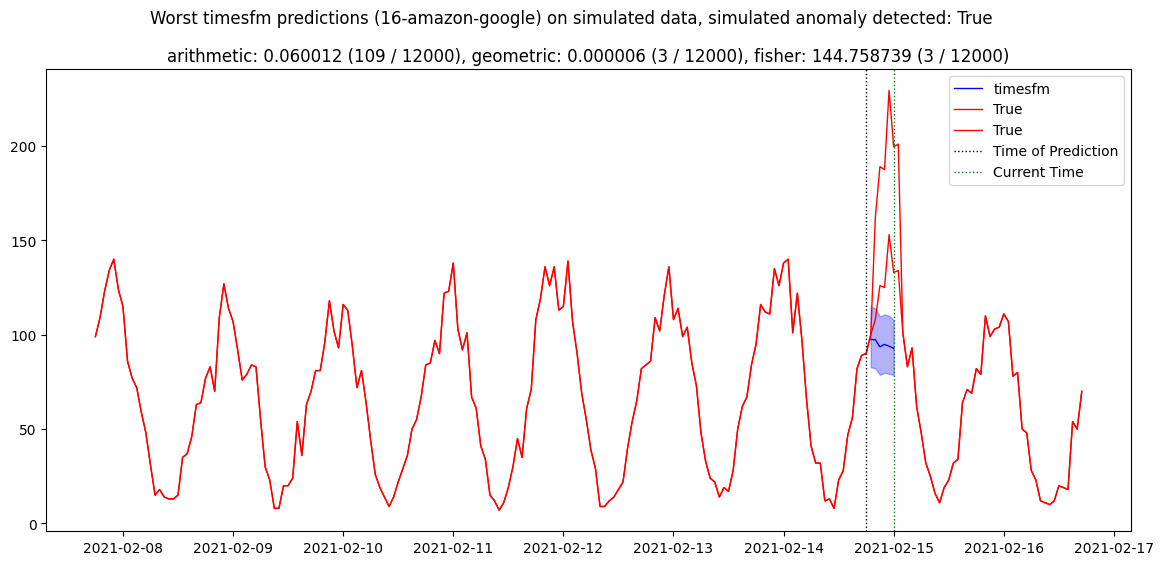

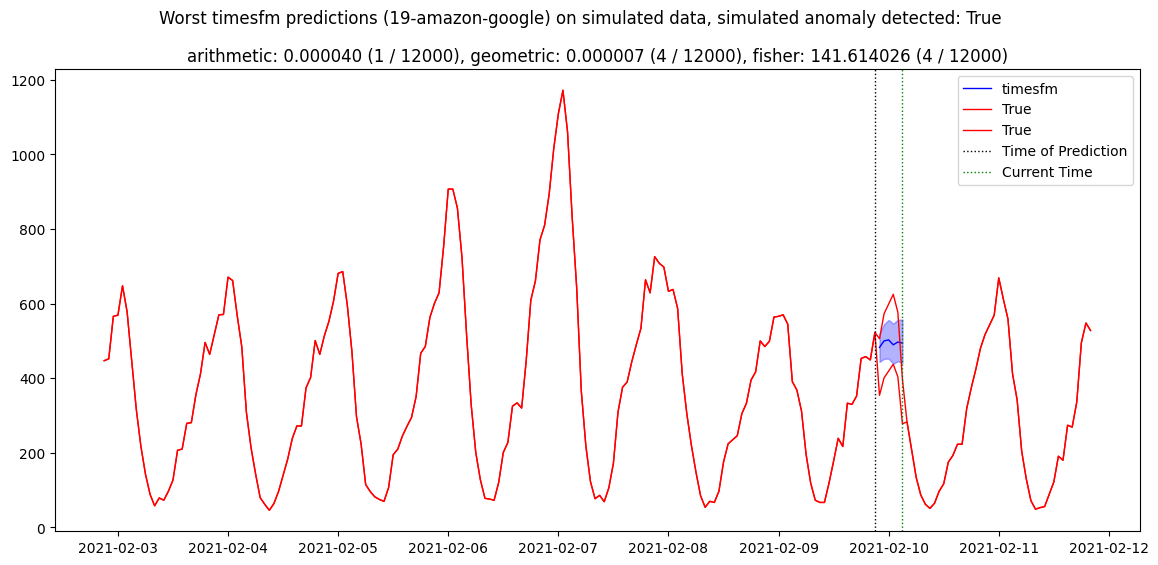

In [47]:
# Get worst scoring predictions with simulated anomalies
k = "6"
steps_ahead = int(k)
graph_before = 24*7

# Get top-k scores
use_topk = True
top_k = 5
method = 'fisher'

if method == 'fisher': # higher is worse
    worst_args = np.argsort(score_dict['anomaly'][method][k])[::-1]
else: # lower is worse
    worst_args = np.argsort(score_dict['anomaly'][method][k])[::1]
    

sorted_scores = {}
for method_name in methods:
    sorted_scores[method_name] = np.sort(score_dict['anomaly'][method_name][k])

ids = set()
for counter, i in enumerate(worst_args):
    id = score_dict['anomaly'][method].iloc[i,0]
    timestamp = score_dict['anomaly'][method].iloc[i,1]
    if use_topk:
        if counter == top_k:
            break
    else:
        if id in ids:
            continue
        ids.add(id)

    plt.figure(figsize=(14,6))
    plot_forecasts(true_df, true_lower_df, true_higher_df, id, timestamp, freq_delta, steps_ahead)
    plot_df(true_data_df, id, timestamp, freq_delta, graph_before, steps_ahead)
    plot_df(data_df, id, timestamp, freq_delta, graph_before, steps_ahead)
    plt.axvline(x=timestamp, color='black', linewidth=1, linestyle=':', label='Time of Prediction')
    plt.axvline(x=timestamp+pd.Timedelta(steps_ahead, 'h'), color='green', linewidth=1, linestyle=':', label='Current Time')

    scores = {}
    ranks = {}
    for score_method, score_df_method in score_dict['anomaly'].items():
        total = sorted_scores[score_method].shape[0]
        scores[score_method] = score_df_method.loc[(score_df_method["unique_id"]==id) & (score_df_method["ds"]==timestamp), k].item()
        rank = np.where(sorted_scores[score_method]==scores[score_method])[0][0]
        if score_method == 'fisher':
            rank = total - rank -1
        ranks[score_method] = rank
        
    act_pos = ((anomaly_dates[str(id)] >= timestamp) & (anomaly_dates[str(id)] < (timestamp + steps_ahead*freq_delta))).any()
    plt.suptitle(f"Worst {model} predictions ({id}-{dataset}) on simulated data, simulated anomaly detected: {act_pos}")
    plt.title(f"arithmetic: {scores['arithmetic']:.6f} ({ranks['arithmetic']} / {total}), geometric: {scores['geometric']:.6f} ({ranks['geometric']} / {total}), fisher: {scores['fisher']:.6f} ({ranks['fisher']} / {total})")
    plt.legend()
    plt.show()
